In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import numba
from scipy.io import wavfile
from IPython.display import Audio

In [10]:
# Simulation settings
Nx = 101
Nt = 500000
dt = 5e-6

# Sampling settings
samplerate = 44000
down_rate_factor = int(1 / (dt * samplerate))

# Guitar settings
NOTE_FREQUENCIES = {'E': 82, 'A': 108, 'D': 146.83, 'G': 193, 'B': 246, 'e': 331}
STRING_NAMES = ['e', 'B', 'G', 'D', 'A', 'E']
SCALE_LENGTH = 0.65
NECK_LENGTH = 0.43
NUMBER_OF_FRETS = 19
AMPLITUDE = 0.002

# Wave Equation settings
l=5e-5
gamma=5e-5

In [11]:
def get_note_frequency(note):
    return NOTE_FREQUENCIES.get(note, 0)
    
def get_initial_condition(initial_length, total_length):
    x = np.linspace(0, total_length, Nx)
    sigma = 0.1  
    y = np.exp(-(x - initial_length)**2 / (2 * sigma**2))
    return AMPLITUDE* y / np.max(y)  

def get_note_position(note_number):
    n = NUMBER_OF_FRETS - note_number
    note_length = SCALE_LENGTH - NECK_LENGTH
    for i in range(n):
        note_length += 1/100 + i/1000 + 2/1000
        if i/10 >= 1.5:
            note_length += 1/1000
    return note_length - 1/1000


In [37]:
@numba.jit("f8[:,:](f8[:,:], i8, i8, f8, f8, f8, f8, f8)", nopython=True, nogil=True)
def get_solution(d, times, length, dt, dx, l, gamma, c):
    for t in range(1, times-1):
        for i in range(2, length-2):
            outer_fact = (1/(c**2 * dt**2) + gamma/(2*dt))**(-1)
            p1 = 1/dx**2 * (d[t][i-1] - 2*d[t][i] + d[t][i+1])
            p2 = 1/(c**2 * dt**2) * (d[t-1][i] - 2*d[t][i])
            p3 = gamma/(2*dt) * d[t-1][i]
            p4 = l**2 / dx**4 * (d[t][i+2] - 4*d[t][i+1] + 6*d[t][i] - 4*d[t][i-1] + d[t][i-2])
            d[t+1][i] = outer_fact * (p1 - p2 + p3 - p4)
    return d

def get_harmonic(n, sol):
    sin_arr = np.sin(n*np.pi*np.linspace(0,1,Nx))
    return np.multiply(sol, sin_arr).sum(axis=1)

def create_note(noteNumber, string):
    c = 2*SCALE_LENGTH*get_note_frequency(string)
    noteLength = get_note_position(noteNumber)
    dx = noteLength/(Nx-1)
    y0 = get_initial_condition(SCALE_LENGTH/4, noteLength)

    sol = np.zeros((Nt, Nx))
    sol[0] = y0
    sol[1] = y0
    sol = get_solution(sol, Nt, Nx, dt, dx, l, gamma, c)
    
    hms = [get_harmonic(n, sol) for n in range(10)]
    return sum(hms)[::down_rate_factor], sol

def play_note(note, name='note'):
    tot = note.astype(np.float32)
    wavfile.write(f'{name}.wav',int(1/(dt*down_rate_factor)),tot)
    return Audio(f'{name}.wav')

def create_chord_animation(note_numbers, name='test'):
    strings = []
    chord = np.zeros(int(Nt/down_rate_factor))
    for i in range(6):
        if note_numbers[i] == 'N':
            string = np.zeros((Nt, Nx))
            note_numbers[i] = 0
        else: 
            string = np.zeros((Nt, int(Nx * SCALE_LENGTH / get_note_position(note_numbers[i]))))
            note, solution = create_note(note_numbers[i], STRING_NAMES[i])
            string[:, :Nx] = solution
            chord += note
        string[:, :] += i * 2 * AMPLITUDE
        strings.append(string)
    play_note(chord, name)

    fps = 30
    def animate(i):
        ax.clear()
        for n, string in enumerate(strings):
            string_frame = string[int(i/(dt*fps))]
            ax.plot(get_note_position(note_numbers[n]) / SCALE_LENGTH * np.arange(len(string_frame)), string_frame, color='white')
        ax.set_ylim(-AMPLITUDE, 12*AMPLITUDE)
        ax.axis('off')
        ax.set_facecolor('black')
    fig, ax = plt.subplots(1,1,figsize=((25,12)))
    ax.set_ylim(-AMPLITUDE, 12*AMPLITUDE)
    ani = animation.FuncAnimation(fig, animate, frames=int(Nt*dt*fps))
    ani.save(f'{name}.mp4',writer='ffmpeg',fps=fps,savefig_kwargs={'facecolor':'black'})

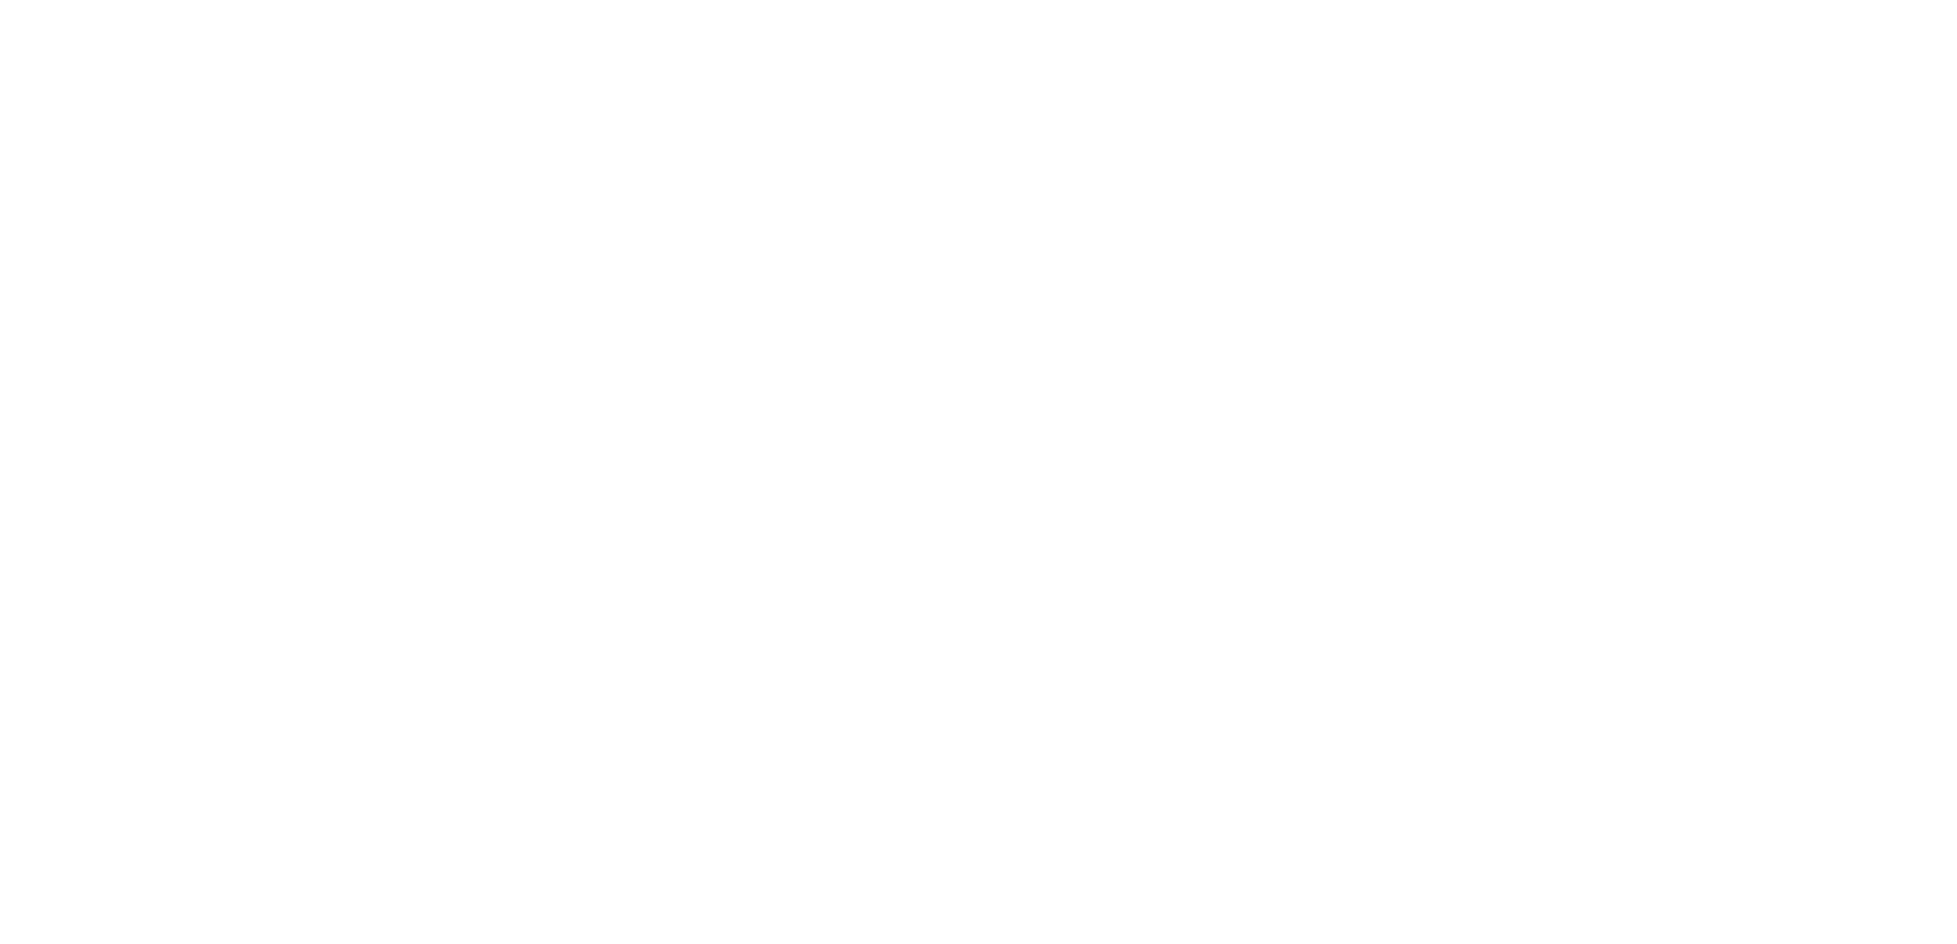

In [38]:
create_chord_animation(['N','N','N','N','N','N'],'Silence')
create_chord_animation(['N','N','N',5,5,'N'],'DA55')
create_chord_animation(['N','N',3,3,'N','N'],'GD33')
create_chord_animation(['N','N',5,5,'N','N'],'GD55')
create_chord_animation(['N','N',6,6,'N','N'],'GD66')
create_chord_animation(['N','N','N','N','N',0],'E0')
create_chord_animation(['N','N','N','N','N',1],'E1')
create_chord_animation(['N','N','N','N','N',2],'E2')
create_chord_animation(['N','N','N','N','N',3],'E3')
create_chord_animation(['N',1,0,'N','N',3],'BGE1')
create_chord_animation(['N','N',0,0,'N',3],'GDE3')
create_chord_animation(['N','N',3,3,'N',3],'GDE333')
create_chord_animation(['N',1,0,'N','N',3],'BGE1')
create_chord_animation(['N',2,1,'N','N',3],'BGE213')
create_chord_animation(['N','N','N','N',3,'N'],'A3')
create_chord_animation(['N','N',3,3,1,'N'],'GDA331')
create_chord_animation(['N','N','N','N',1,'N'],'A1')


In [ ]:
# Across the Universe
createChordAndmakeChordAnimation([0,2,2,4,4,2],['N','B','G','D','A','E'],'Fm#1')
createChordAndmakeChordAnimation([0,2,4,4,4,2],['N','B','G','D','A','E'],'Fm#2')
createChordAndmakeChordAnimation([0,2,2,2,0,0],['N','B','G','D','A','N'],'A1')
createChordAndmakeChordAnimation([0,2,4,2,0,0],['N','B','G','D','A','N'],'A2')
createChordAndmakeChordAnimation([2,3,2,0,0,0],['e','B','G','D','N','N'],'D')
createChordAndmakeChordAnimation([2,3,4,4,1,0],['e','B','G','D','A','N'],'Bm')
createChordAndmakeChordAnimation([2,2,2,4,4,2],['e','B','G','D','A','E'],'F#m')
createChordAndmakeChordAnimation([0,3,0,2,2,0],['e','B','G','D','A','E'],'Em7')